# Start

In this guide, we'll show how you can use EvalML to automatically find the best pipeline for predicting whether a patient has breast cancer. Along the way, we'll highlight EvalML's built-in tools and features for understanding and interacting with the search process.

In [1]:
import evalml
from evalml import AutoMLSearch

2020-12-17 19:45:06,386 featuretools - WARNING    Featuretools failed to load plugin nlp_primitives from library nlp_primitives. For a full stack trace, set logging to debug.


First, we load in the features and outcomes we want to use to train our model.

In [2]:
X, y = evalml.demos.load_breast_cancer()

EvalML has many options to configure the pipeline search. At the minimum, we need to define an objective function. For simplicity, we will use the F1 score in this example. However, the real power of EvalML is in using domain-specific [objective functions](user_guide/objectives.ipynb) or [building your own](user_guide/objectives.ipynb).

Below EvalML utilizes Bayesian optimization (EvalML's default optimizer) to search and find the best pipeline defined by the given objective.

EvalML provides a number of parameters to control the search process. `max_batches` is one of the parameters which controls the stopping criterion for the AutoML search. It indicates the maximum number of rounds of AutoML to evaluate, where each round may train and score a variable number of pipelines. In this example, `max_batches` is set to 1.

** Graphing methods, like AutoMLSearch, on Jupyter Notebook and Jupyter Lab require [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/user_install.html) to be installed.

** If graphing on Jupyter Lab, [jupyterlab-plotly](https://plotly.com/python/getting-started/#jupyterlab-support-python-35) required. To download this, make sure you have [npm](https://nodejs.org/en/download/) installed.

In [3]:
automl = AutoMLSearch(problem_type="binary", objective="f1", max_batches=1)

In order to validate the results of the pipeline creation and optimization process, we will save some of our data as a holdout set.

In [4]:
X_train, X_holdout, y_train, y_holdout = evalml.preprocessing.split_data(X, y, test_size=.2)

__Note:__ To provide data to EvalML, it is recommended that you create a `DataTable` object using [the Woodwork project](https://woodwork.alteryx.com/en/stable/). Here, `split_data()` returns Woodwork data structures.

EvalML also accepts and works well with pandas `DataFrames`. But using the `DataTable` makes it easy to control how EvalML will treat each feature, as a numeric feature, a categorical feature, a text feature or other type of feature. Woodwork's `DataTable` includes features like inferring when a categorical feature should be treated as a text feature. For this reason, if you don't provide Woodwork objects, EvalML will raise a warning.

When we call `search()`, the search for the best pipeline will begin. There is no need to wrangle with missing data or categorical variables as EvalML includes various preprocessing steps (like imputation, one-hot encoding, feature selection) to ensure you're getting the best results. As long as your data is in a single table, EvalML can handle it. If not, you can reduce your data to a single table by utilizing [Featuretools](https://featuretools.featurelabs.com) and its Entity Sets.

You can find more information on pipeline components and how to integrate your own custom pipelines into EvalML [here](user_guide/pipelines.ipynb).

In [5]:
automl.search(X_train, y_train)

Generating pipelines to search over...
*****************************
* Beginning pipeline search *
*****************************

Optimizing for F1. 
Greater score is better.

Searching up to 1 batches for a total of 9 pipelines. 
Allowed model families: lightgbm, random_forest, catboost, extra_trees, linear_model, xgboost, decision_tree



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Batch 1: (1/9) Mode Baseline Binary Classification P... Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean F1: 0.000
Batch 1: (2/9) Logistic Regression Classifier w/ Imp... Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean F1: 0.982
Batch 1: (3/9) Random Forest Classifier w/ Imputer      Elapsed:00:05
	Starting cross validation
	Finished cross validation - mean F1: 0.949
Batch 1: (4/9) XGBoost Classifier w/ Imputer            Elapsed:00:07
	Starting cross validation
	Finished cross validation - mean F1: 0.965
Batch 1: (5/9) CatBoost Classifier w/ Imputer           Elapsed:00:07
	Starting cross validation
	Finished cross validation - mean F1: 0.939
Batch 1: (6/9) Elastic Net Classifier w/ Imputer + S... Elapsed:00:08
	Starting cross validation
	Finished cross validation - mean F1: 0.514
High coefficient of variation (cv >= 0.2) within cross validation scores. Elastic Net Classifier w/ Imputer + Standard Scaler may not perform as estimated

After the search is finished we can view all of the pipelines searched, ranked by score. Internally, EvalML performs cross validation to score the pipelines. If it notices a high variance across cross validation folds, it will warn you. EvalML also provides additional [data checks](user_guide/data_checks.ipynb) to analyze your data to assist you in producing the best performing pipeline. 

In [6]:
automl.rankings

,id,pipeline_name,score,validation_score,percent_better_than_baseline,high_variance_cv,parameters
0,1,Logistic Regression Classifier w/ Imputer + St...,0.982089,0.991150,NaN,False,{'Imputer': {'categorical_impute_strategy': 'm...
1,3,XGBoost Classifier w/ Imputer,0.964753,0.973451,NaN,False,{'Imputer': {'categorical_impute_strategy': 'm...
2,7,LightGBM Classifier w/ Imputer,0.952871,0.954128,NaN,False,{'Imputer': {'categorical_impute_strategy': 'm...
3,2,Random Forest Classifier w/ Imputer,0.948698,0.945455,NaN,False,{'Imputer': {'categorical_impute_strategy': 'm...
4,6,Extra Trees Classifier w/ Imputer,0.945222,0.925926,NaN,False,{'Imputer': {'categorical_impute_strategy': 'm...
5,4,CatBoost Classifier w/ Imputer,0.939090,0.917431,NaN,False,{'Imputer': {'categorical_impute_strategy': 'm...
6,8,Decision Tree Classifier w/ Imputer,0.907870,0.955752,NaN,False,{'Imputer': {'categorical_impute_strategy': 'm...
7,5,Elastic Net Classifier w/ Imputer + Standard S...,0.513875,0.658824,NaN,True,{'Imputer': {'categorical_impute_strategy': 'm...
8,0,Mode Baseline Binary Classification Pipeline,0.000000,0.000000,NaN,False,{'Baseline Classifier': {'strategy': 'mode'}}


If we are interested in see more details about the pipeline, we can view a summary description using the `id` from the rankings table:

In [7]:
automl.describe_pipeline(3)

*********************************
* XGBoost Classifier w/ Imputer *
*********************************

Problem Type: binary
Model Family: XGBoost

Pipeline Steps
1. Imputer
	 * categorical_impute_strategy : most_frequent
	 * numeric_impute_strategy : mean
	 * categorical_fill_value : None
	 * numeric_fill_value : None
2. XGBoost Classifier
	 * eta : 0.1
	 * max_depth : 6
	 * min_child_weight : 1
	 * n_estimators : 100

Training
Training for binary problems.
Total training time (including CV): 0.6 seconds

Cross Validation
----------------
               F1  MCC Binary  Log Loss Binary   AUC  Precision  Balanced Accuracy Binary  Accuracy Binary # Training # Testing
0           0.973       0.958            0.050 0.998      0.982                     0.977            0.980    303.000   152.000
1           0.957       0.930            0.117 0.986      0.948                     0.967            0.967    303.000   152.000
2           0.964       0.943            0.090 0.992      0.964        

We can also view the pipeline parameters directly:

In [8]:
pipeline = automl.get_pipeline(3)
print(pipeline.parameters)

{'Imputer': {'categorical_impute_strategy': 'most_frequent', 'numeric_impute_strategy': 'mean', 'categorical_fill_value': None, 'numeric_fill_value': None}, 'XGBoost Classifier': {'eta': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100}}


We can now select the best pipeline and score it on our holdout data:

In [9]:
pipeline = automl.best_pipeline
pipeline.fit(X_train, y_train)
pipeline.score(X_holdout, y_holdout, ["f1"])

OrderedDict([('F1', 0.9268292682926829)])

We can also visualize the structure of the components contained by the pipeline:

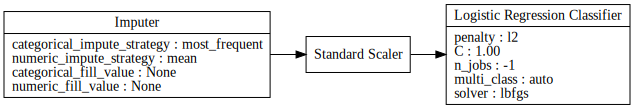

In [10]:
pipeline.graph()